In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

In [2]:
def load_mat_data(train_data_path, test_data_path):
    # 加载训练数据
    train_mat = scipy.io.loadmat(train_data_path)
    train_data = np.array(train_mat['train_data_5'], dtype='float32')
    train_labels = np.array(train_mat['train_label_5'], dtype='float32').squeeze()  # 从2D转换为1D
    
    # 加载测试数据
    test_mat = scipy.io.loadmat(test_data_path)
    test_data = np.array(test_mat['test_data_5'], dtype='float32')
    test_labels = np.array(test_mat['test_label_5'], dtype='float32').squeeze()  # 从2D转换为1D
    
    return train_data, train_labels, test_data, test_labels

# 设置数据路径
train_data_path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/train_5.mat'
test_data_path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/test_5.mat'

# 加载数据
train_data, train_labels, test_data, test_labels = load_mat_data(train_data_path, test_data_path)

# 因为1D CNN需要一个额外的维度，我们将数据重塑
train_data = train_data.reshape((-1, 3072, 1))
test_data = test_data.reshape((-1, 3072, 1))

# 对数据进行归一化处理
train_data /= np.max(train_data)
test_data /= np.max(test_data)



In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# 定义学习率衰减函数
# def scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
import math

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * math.exp(-0.1)  # 使用math的exp


# 定义模型
model = models.Sequential([
    layers.Reshape((32, 96, 1), input_shape=(3072,)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# 编译模型
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 32, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 24, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 24, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 24, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 24, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 24, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 4, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     1,573,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,863,018 (7.11 MB)

 Trainable params: 1,862,570 (7.11 MB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# 设置回调函数进行学习率衰减和早停
lr_scheduler = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    train_data, train_labels, 
    epochs=20,
    validation_data=(test_data, test_labels),
    callbacks=[lr_scheduler, early_stopping]
)

# 可视化训练过程
# ...（与之前的可视化代码相同，省略）


Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 75s 131ms/step - accuracy: 0.3165 - loss: 2.4074 - val_accuracy: 0.1000 - val_loss: 15.7798 - learning_rate: 0.0010
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 71s 127ms/step - accuracy: 0.4336 - loss: 1.4468 - val_accuracy: 0.3740 - val_loss: 1.5022 - learning_rate: 0.0010
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.4910 - loss: 1.2032 - val_accuracy: 0.4715 - val_loss: 1.0803 - learning_rate: 0.0010
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 70s 124ms/step - accuracy: 0.5762 - loss: 1.0553 - val_accuracy: 0.2720 - val_loss: 1.9770 - learning_rate: 0.0010
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 70s 124ms/step - accuracy: 0.6531 - loss: 0.8875 - val_accuracy: 0.6920 - val_loss: 0.6756 - learning_rate: 0.0010
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 70s 124ms/step - accuracy: 0.6847 - loss: 0.7765 - val_accuracy: 0.4020 - val_loss: 2.1928 - learning_rate: 0.0010
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 68s 121ms/step - accuracy: 0.

In [12]:
# 在测试集上评估模型
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)


63/63 - 2s - 32ms/step - accuracy: 0.7235 - loss: 0.5571

Test accuracy: 0.7235000133514404


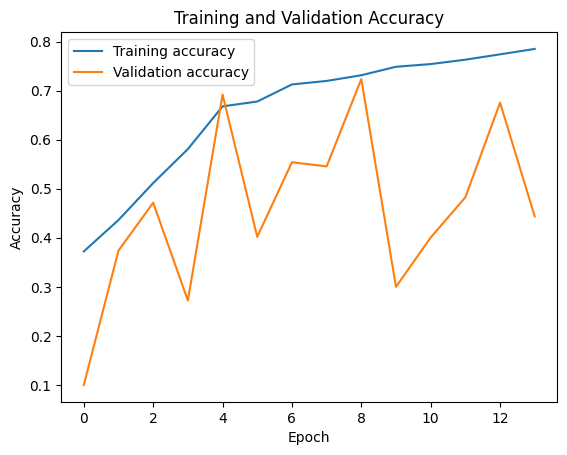

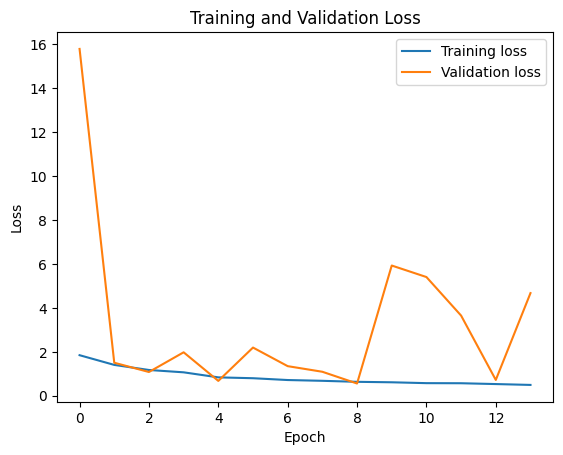

In [13]:
# 可视化训练过程
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
              precision    recall  f1-score   support

           0       0.45      0.47      0.46       200
           1       1.00      1.00      1.00       200
           2       0.99      0.82      0.90       200
           3       0.54      0.98      0.70       200
           4       1.00      1.00      1.00       200
           5       0.66      1.00      0.79       200
           6       0.97      0.42      0.59       200
           7       1.00      1.00      1.00       200
           8       0.00      0.00      0.00       200
           9       0.40      0.54      0.46       200

    accuracy                           0.72      2000
   macro avg       0.70      0.72      0.69      2000
weighted avg       0.70      0.72      0.69      2000



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

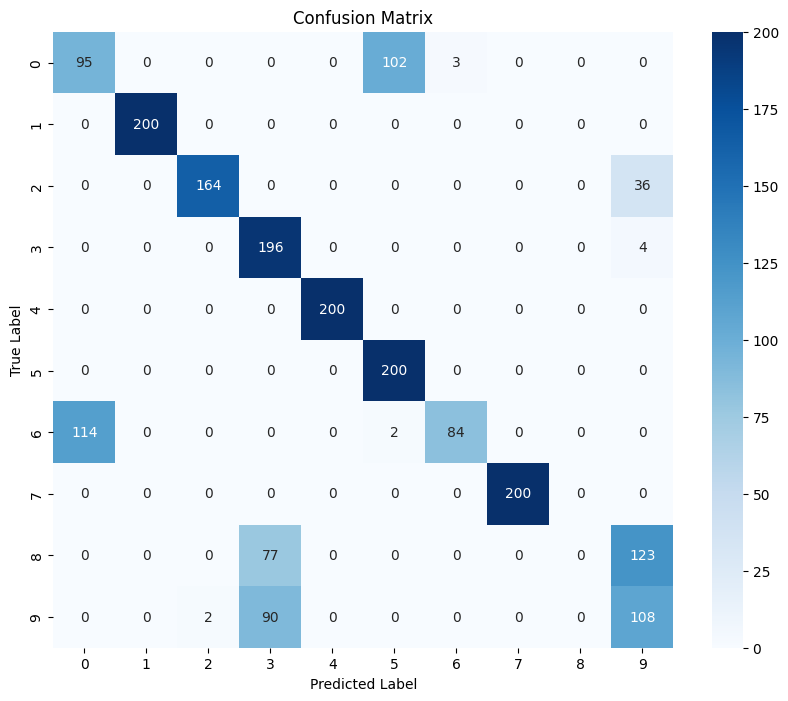

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 预测测试数据集
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# 计算并显示分类报告
report = classification_report(test_labels, predicted_classes, target_names=[str(i) for i in range(10)])  # 假设有10个类别
print(report)

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [15]:
model.save('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/CNN0327-3.h5')  # HDF5文件

In [20]:
# HDF5格式
loaded_model = tf.keras.models.load_model('/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/model/CNN0327-3.h5')

In [21]:
# 在测试集上评估模型
test_loss, test_acc = loaded_model.evaluate(test_data, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

63/63 - 2s - 35ms/step - accuracy: 0.7235 - loss: 0.5571

Test accuracy: 0.7235000133514404


In [22]:
def load_mat_data(train_data_path, test_data_path):
    # 加载训练数据
    train_mat = scipy.io.loadmat(train_data_path)
    train_data = np.array(train_mat['train_data_10'], dtype='float32')
    train_labels = np.array(train_mat['train_label_10'], dtype='float32').squeeze()  # 从2D转换为1D
    
    # 加载测试数据
    test_mat = scipy.io.loadmat(test_data_path)
    test_data = np.array(test_mat['test_data_10'], dtype='float32')
    test_labels = np.array(test_mat['test_label_10'], dtype='float32').squeeze()  # 从2D转换为1D
    
    return train_data, train_labels, test_data, test_labels

# 设置数据路径
train_data_path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/train_10.mat'
test_data_path = '/Users/fuyao/Documents/GitHub/DL-based-RF-Fingerprints-Recognition/database/test_10.mat'

# 加载数据
train_data, train_labels, test_data, test_labels = load_mat_data(train_data_path, test_data_path)

# 因为1D CNN需要一个额外的维度，我们将数据重塑
train_data = train_data.reshape((-1, 3072, 1))
test_data = test_data.reshape((-1, 3072, 1))

# 对数据进行归一化处理
train_data /= np.max(train_data)
test_data /= np.max(test_data)

KeyError: 'train_data_5'

In [ ]:
# 在测试集上评估模型
test_loss, test_acc = loaded_model.evaluate(test_data, test_labels, verbose=2)

print('\nTest accuracy:', test_acc)